In [25]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import copy
import os

import sys
import time
from scipy.stats import norm

#import prettyplotlib as ppl
import matplotlib.pyplot as plt
import matplotlib as mpl
#import prettyplotlib as ppl
#from prettyplotlib import brewer2mpl
import matplotx
import numpy as np
import pandas as pd
import seaborn as sns

from helper import df_to_latex, fig_path, set_figsize, tab_path

# Import code from src
sys.path.insert(0, '../src/')
import vmc 


# Set plot style
#context="paper" context="paper", style="darkgrid",
#rc={"axes.facecolor": "0.96"}
sns.set(rc={"axes.facecolor": "1.00"}, palette="tab10")

fontsize = "large"

params = {"font.family": "serif",
          "font.sans-serif": ["Computer Modern"],
          "axes.labelsize": fontsize,
          "legend.fontsize": fontsize,
          "xtick.labelsize": fontsize,
          "ytick.labelsize": fontsize,
          "legend.handlelength": 2
          }


plt.rcParams.update(params)
plt.rc('text', usetex=True)

"""
# Set plot style
sns.set(context="paper", style='darkgrid', rc={"axes.facecolor": "0.96"})

# Set fontsizes in figures
fontsize = 10
tex_fonts = {
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern"],
    "axes.labelsize": fontsize,
    "font.size": fontsize,
    "legend.fontsize": fontsize,
    "xtick.labelsize": fontsize-1,
    "ytick.labelsize": fontsize-1,
    'legend.handlelength': 2
}

plt.rcParams.update(tex_fonts)
"""
# Set figure size
width = 410 #360
figsize = set_figsize(width, fraction=1)

In [3]:
def exact_energy(N, dim, omega):
    return (omega * dim * N) / 2

def safe_initial_positions_no_interactions(wavefunction, alpha, N, dim, seed=None):
    rng = np.random.default_rng(seed=seed)
    positions = rng.random(size=(N, dim))

    # safe initialization
    wf2 = wavefunction.pdf(positions, alpha)
    while np.sum(wf2) <= 1e-14:
        positions *= 0.5
        wf2 = wavefunction.pdf(positions, alpha)

    return positions

def safe_initial_positions_w_interactions(wavefunction, alpha, N, dim, seed=None): 
    rng = np.random.default_rng(seed=seed)
    positions = rng.random(size=(N, dim))
    
    # safe initialization
    wf2 = wavefunction.pdf(positions, alpha)
    while np.sum(wf2) <= 1e-14: 
        positions *= 2.0
        wf2 = wavefunction.pdf(positions, alpha)
        
    return positions

def interact_initial_positions(wf, alpha, N, dim, a=0.00433):

    rng = np.random.default_rng()

    def corr_factor(r1, r2):
        rij = np.linalg.norm(r1 - r2)
        if rij <= a:
            return 0.
        else:
            return 1 - (a / rij)

    scale = 2.
    r = np.random.randn(N, dim) * scale
    #r = rng.random(size=(N, dim))

    rerun = True
    while rerun:
        rerun = False
        for i in range(N):
            for j in range(i + 1, N):
                corr = corr_factor(r[i, :], r[j, :])
                if corr == 0.:
                    print("corr=0 encountered")
                    rerun = True
                    r[i, :] = np.random.randn() * scale
                    r[j, :] = np.random.randn() * scale
        scale *= 1.5

    return r, scale

def get_mean_w_standard_error_grid_search(data, alphas): 
    data_dict = {"alpha": alphas, "energy": [], "standard_error":[],"standard_error_of_the_mean": []}
    for i, alpha in enumerate(alphas): 
        energies_alpha = data["energy"][data["alpha"]==alpha]
        standard_errors_alpha = data["standard_error"][data["alpha"]==alpha]
        mean_energy_alpha = np.mean(energies_alpha)
        standard_error = np.mean(standard_errors_alpha)
        standard_error_of_the_mean = np.std(standard_errors_alpha)/np.sqrt(len(standard_errors_alpha))
        data_dict["energy"].append(mean_energy_alpha)
        data_dict["standard_error"].append(standard_error)
        data_dict["standard_error_of_the_mean"].append(standard_error_of_the_mean)
        
    dataframe = pd.DataFrame(data=data_dict)
    return dataframe


In [26]:
cycle=["#82e2ff",  # blue
       "#ffca85",  # orange
       "#61ffca",  # green
       "#ff6767",  # red
       "#a277ff",  # purple
       "#f694ff",  # magenta
       "#6d6d6d",  # gray
       ]



def plotter(data, sampler, label_N_particles, label_time, label_sigma, index): 
    N_range = data[label_N_particles]
    t_array = data[label_time]
    std = data[label_sigma]
    plt.plot(N_range, t_array, label=sampler, color=cycle[index]) 
    plt.errorbar(N_range,
                 t_array,
                 yerr=std,
                 fmt=':o',
                 color=cycle[index],
                 ecolor=cycle[index],
                 markersize=3.5,
                 lw=1.0,
                 elinewidth=1.5,
                 capsize=3,
                )
    #plt.scatter(N_range, t_array, marker="*", s=std)

def plot_dracula(datasets, labels, xlabel, ylabel, features):
    """
    datasets: a list containing the datasets
    labels: a list containing the labels in the legend
    xlabel: xlabel
    ylabel: ylabel
    features: features[0]:x-axis, features[1]:y-axis, features[2]:std y-axis
    """
    with plt.style.context(matplotx.styles.duftify(matplotx.styles.dracula)): 
        for i in range(len(datasets)): 
            plotter(datasets[i], labels[i], features[0], features[1], features[2], i)
        plt.xlabel(xlabel)
        matplotx.ylabel_top(ylabel)
        matplotx.line_labels()
        plt.grid(False)
    plt.savefig(fig_path("time_comparison.pdf"), bbox_inches='tight')

    
    
def box_plot(data,features,xlabels,figure_name):
    fig, axes = plt.subplots(nrows=len(features), ncols=int(len(features)/2), figsize=(6, 4), tight_layout=True, dpi=200)
    #sns.set(rc={"axes.facecolor": "1.00"})
    for i in range(len(features)):
        sns.boxplot(data=data, x=features[i], color="C0", fliersize=0, ax=axes[i])
        sns.swarmplot(data=data, x=features[i], color=".25", ax=axes[i])
        axes[i].set(xlabel=xlabels[i])
        axes[i].grid(False)
        #axes[i].set_facecolor(1.00)
    sns.despine()
    fig.savefig(fig_path(figure_name), bbox_inches='tight')
    
def line_plot(data, features, labels, xlabel, ylabel, figure_name): 
    fig, ax = plt.subplots(1, figsize=(6, 4), tight_layout=True, dpi=200)
    with plt.style.context(matplotx.styles.dufte):
        for i in range(len(data)): 
            sns.lineplot(data=data[i], 
                         x=features[0], 
                         y=features[1], 
                         ax=ax, 
                         label=labels[i], 
                         legend=False, 
                         color=sns.color_palette()[i])
            
            ax.errorbar(data[i][features[0]], 
                        data[i][features[1]], 
                        yerr=data[i][features[2]], 
                        ecolor=sns.color_palette()[i], 
                        fmt=' ', 
                        zorder=-1)
        ax.set(xlabel=xlabel)
        matplotx.ylabel_top(ylabel)
        #ax.legend(False)
        matplotx.line_labels()
        ax.grid(False)
        fig.savefig(fig_path(figure_name), bbox_inches='tight')
        
def line_plot_no_error(data, features, labels, xlabel, ylabel, figure_name): 
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(6, 4), tight_layout=True, dpi=200)
    with plt.style.context(matplotx.styles.dufte):
        for i in range(len(data)): 
            sns.lineplot(data=data[i], 
                         x=features[0], 
                         y=features[i+1], 
                         ax=axes[i], 
                         label=labels[i], 
                         legend=False, 
                         color=sns.color_palette()[i])
            axes[0].hlines(1.5, 0.1, 1.0, ls="dashed", label="Exact")
        axes.set(xlabel=xlabel)
        matplotx.ylabel_top(ylabel)
        #ax.legend(False)
        matplotx.line_labels()
        #ax.grid(False)
        fig.savefig(fig_path(figure_name), bbox_inches='tight')

        


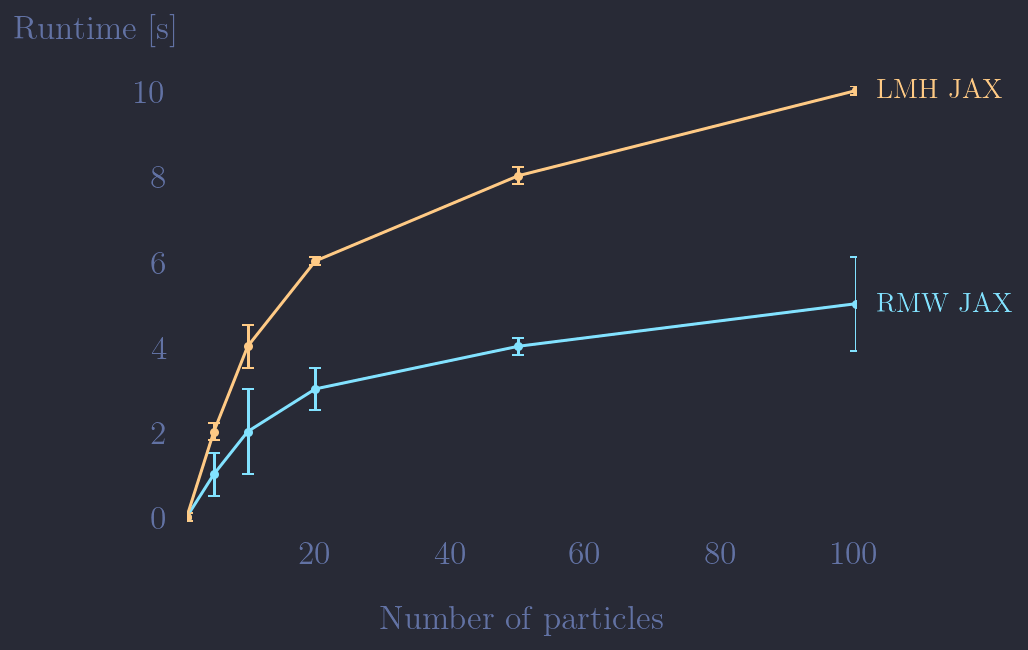

In [4]:
dataset = {"t": [i for i in range(6)], "N_particles":[1, 5, 10, 20, 50, 100], "sigma": [0.1, 0.5, 1.0, 0.5, 0.2, 1.1]}
dataset2 = {"t": [2*i for i in range(6)], "N_particles":[1, 5, 10, 20, 50, 100], "sigma": [0.1, 0.2, 0.5, 0.1, 0.2, 0.1]}
datasets = [pd.DataFrame(data=dataset), pd.DataFrame(data=dataset2)]
plot_dracula(datasets, ["RMW JAX", "LMH JAX"], "Number of particles", "Runtime [s]", ["N_particles", "t", "sigma"])
#plot_prettyplotlib(datasets, ["RMW JAX", "LMH JAX"], "Number of particles", "Runtime [s]", ["N_particles", "t", "sigma"])

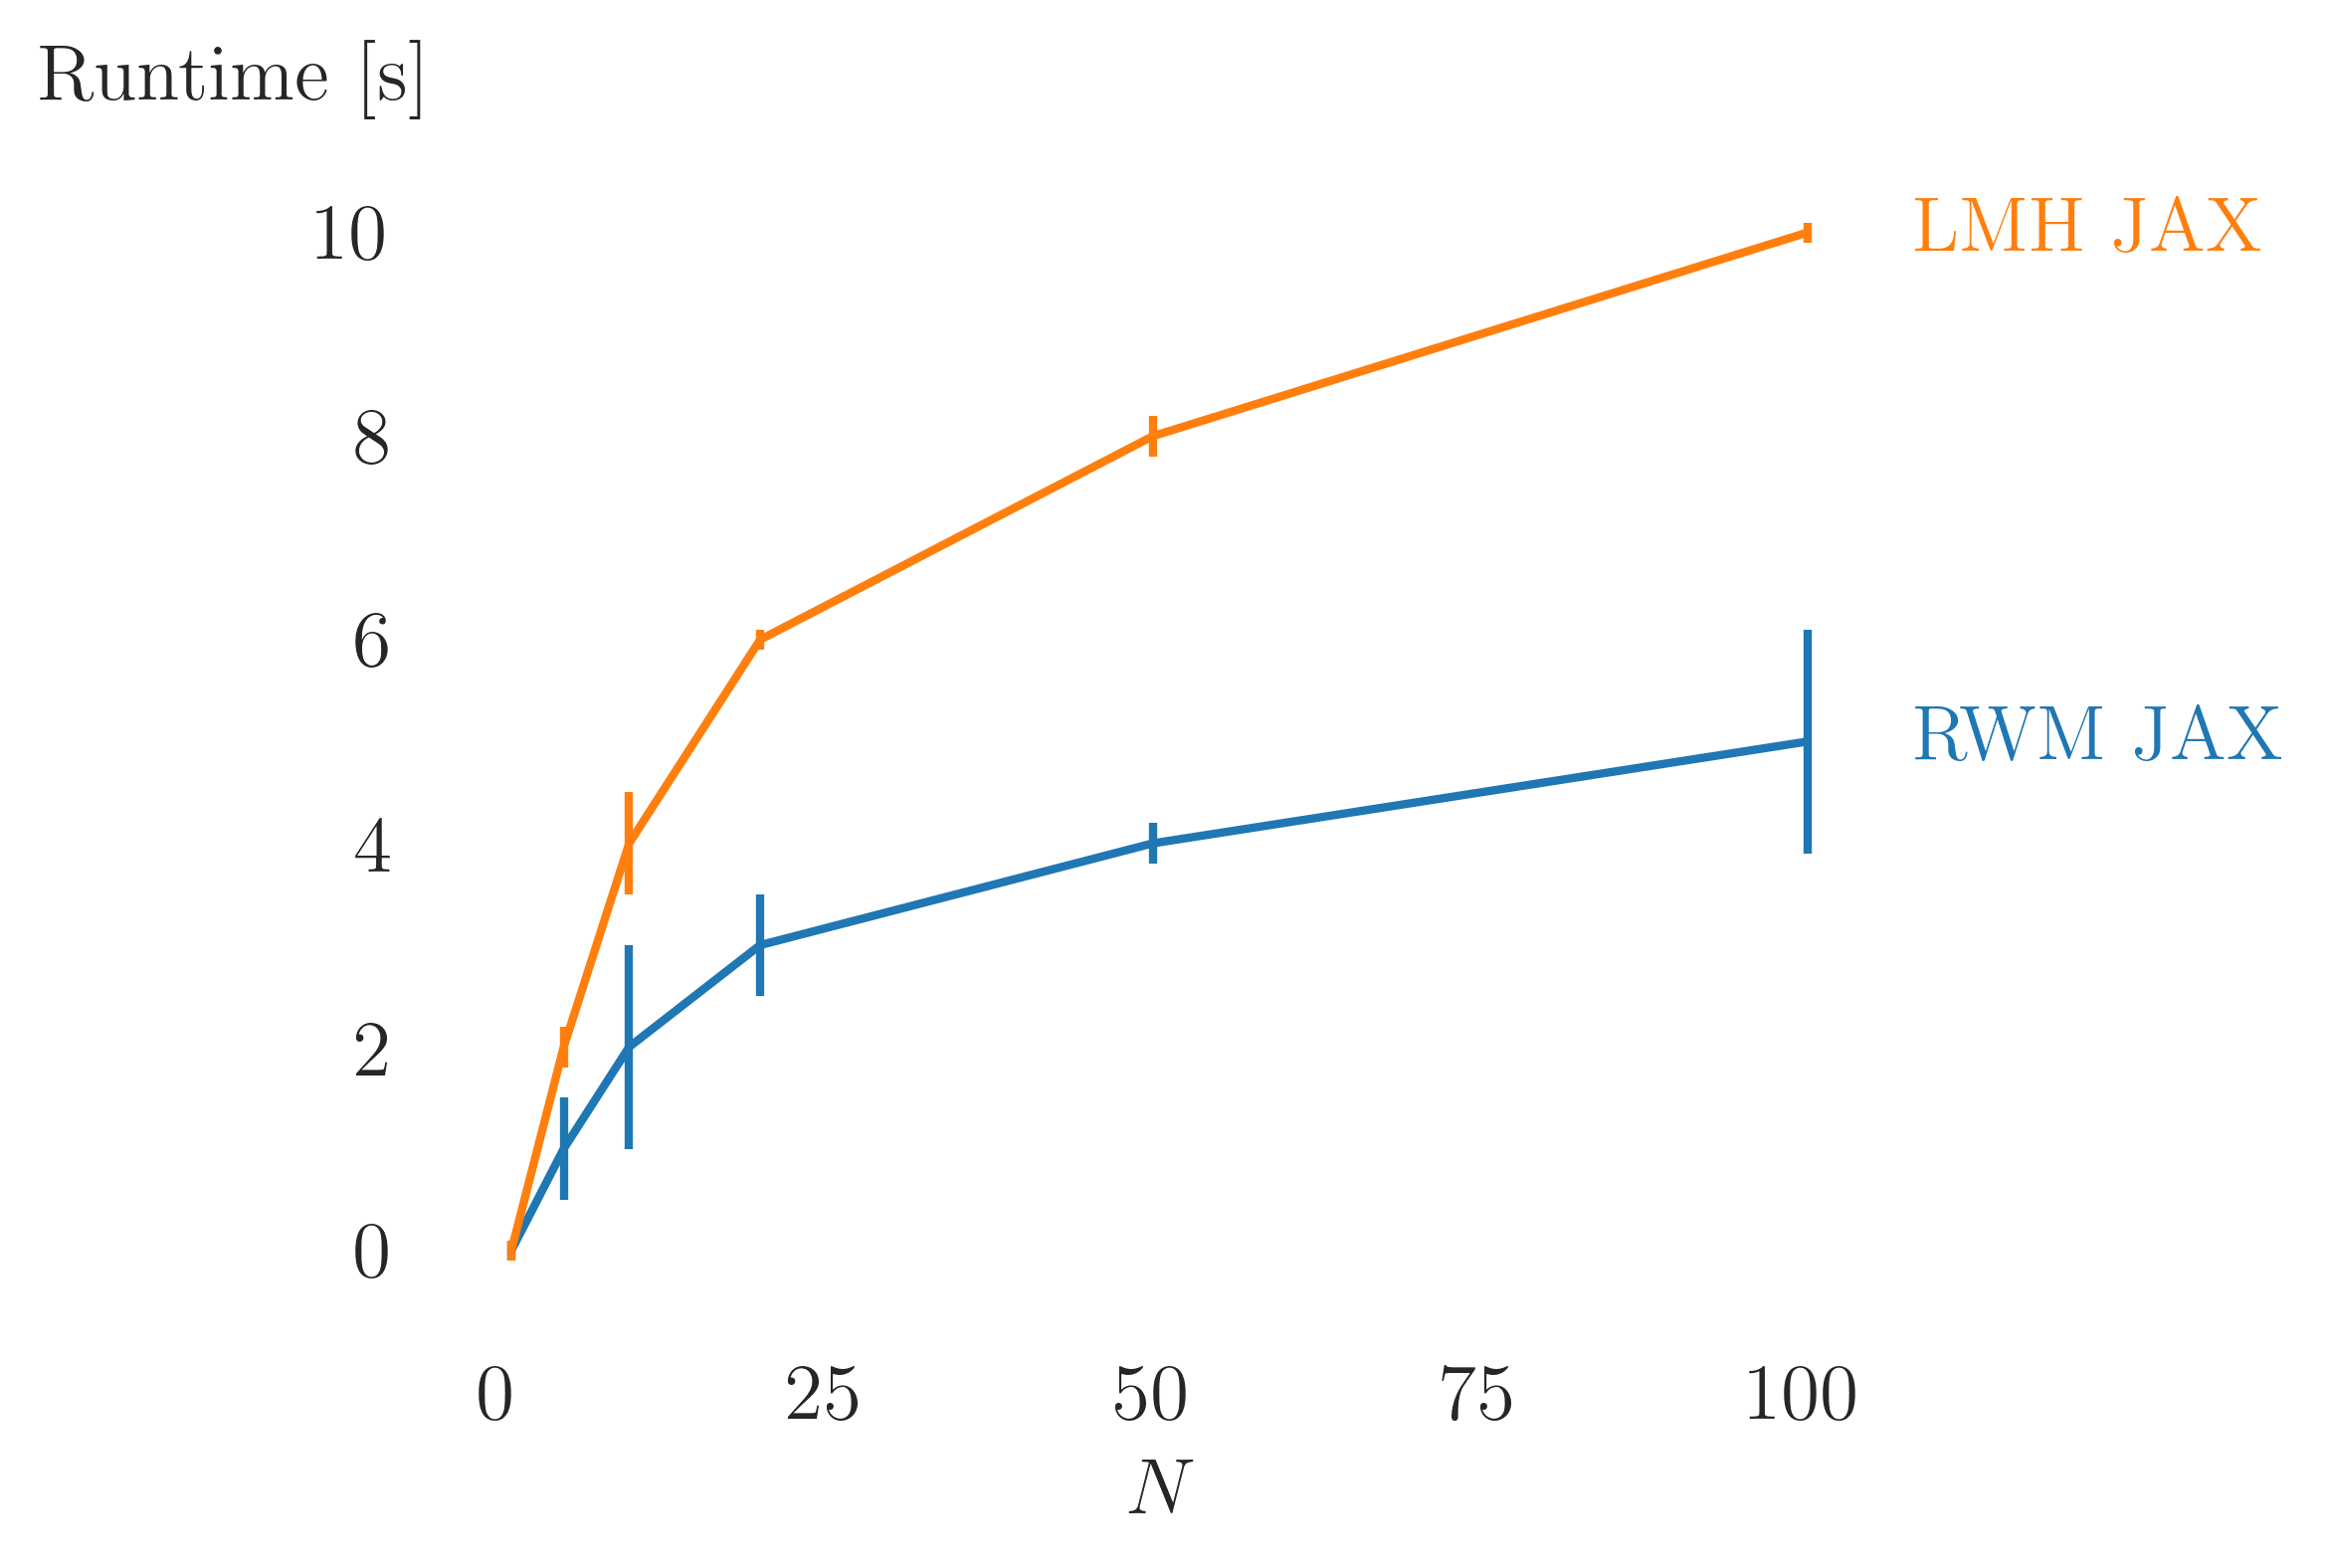

In [5]:
line_plot(datasets, ["N_particles", "t", "sigma"], ["RWM JAX", "LMH JAX"], r'$N$', "Runtime [s]", "line_plot.pdf")

In [6]:
N = 10
dim = 3
omega = 1.0
initial_alpha = 0.5
wf = vmc.AEHONIB(N, dim, omega) # setting a=0, such that the bosons are point particles
sampler = vmc.Metropolis(wf)
nsamples = int(2**16)
initial_positions, scale = interact_initial_positions(wf, initial_alpha, N, dim)
start = time.time()
results = sampler.sample(nsamples, 
                        initial_positions, 
                        initial_alpha, 
                        nchains=4,
                        scale=1.0, 
                        warm=True, 
                        warmup_iter=20000, 
                        tune=True, 
                        tune_iter=30000, 
                        tune_interval=1000,
                        optimize=False,
                        max_iter=200000,
                        batch_size=2000,
                        gradient_method='adam',
                        eta=0.01,
                        tol_optim=1e-7,
                        )
end = time.time()
print("Sampler elapsed time:", end - start)
print(results)

wf = vmc.EHONIB()
sampler = vmc.Metropolis(wf)
initial_positions, scale = interact_initial_positions(wf, initial_alpha, N, dim)
start = time.time()
results_JAX = sampler.sample(nsamples, 
                            initial_positions, 
                            initial_alpha, 
                            nchains=4,
                            scale=1.0, 
                            warm=True, 
                            warmup_iter=20000, 
                            tune=True, 
                            tune_iter=30000, 
                            tune_interval=1000,
                            optimize=False,
                            max_iter=200000,
                            batch_size=2000,
                            gradient_method='adam',
                            eta=0.01,
                            tol_optim=1e-7,
                            )
end = time.time()
print("Sampler elapsed time:", end - start)
print(results_JAX)

Sampler elapsed time: 23.75978970527649
   nparticles  dim  alpha    energy  standard_error  accept_rate
0          10    3    0.5  24.14215             0.0     0.366943
1          10    3    0.5  24.14215             0.0     0.371826
2          10    3    0.5  24.14215             0.0     0.378433
3          10    3    0.5  24.14215             0.0     0.375809
Sampler elapsed time: 90.11511468887329
   nparticles  dim  alpha    energy  standard_error         accept_rate
0          10    3    0.5  24.14215             0.0  0.3148040771484375
1          10    3    0.5  24.14215             0.0  0.3954925537109375
2          10    3    0.5  24.14215             0.0   0.344390869140625
3          10    3    0.5  24.14215             0.0  0.3325958251953125


In [7]:
N = 10
dim = 3
omega = 1.0
initial_alpha = 0.5
wf = vmc.AEHOIB(N, dim, omega) # setting a=0, such that the bosons are point particles
sampler = vmc.Metropolis(wf)
nsamples = int(2**16)
results = []
initial_positions, scale = interact_initial_positions(wf, initial_alpha, N, dim)
for i in range(2): 
    start = time.time()
    result = sampler.sample(nsamples, 
                        initial_positions, 
                        initial_alpha, 
                        nchains=4,
                        scale=1.0, 
                        warm=True, 
                        warmup_iter=20000, 
                        tune=True, 
                        tune_iter=30000, 
                        tune_interval=1000,
                        optimize=True,
                        max_iter=200000,
                        batch_size=2000,
                        gradient_method='adam',
                        eta=0.01,
                        tol_optim=1e-7,
                        )
    end = time.time()
    print(result)
    results.append(result)
    print("Sampler elapsed time:", end - start)
results = pd.concat(results, ignore_index=True)
print(results)

   nparticles  dim     alpha     energy  standard_error  accept_rate
0          10    3  0.499841  24.470415        0.001703     0.371124
1          10    3  0.497291  24.453706        0.001786     0.315445
2          10    3  0.499231  24.456554        0.001494     0.302597
3          10    3  0.498557  24.461294        0.001597     0.326935
Sampler elapsed time: 349.64948296546936
   nparticles  dim     alpha     energy  standard_error  accept_rate
0          10    3  0.498181  24.459558        0.001699     0.325562
1          10    3  0.500116  24.459474        0.001648     0.331329
2          10    3  0.500748  24.476252        0.002011     0.380371
3          10    3  0.500333  24.475064        0.001984     0.378006
Sampler elapsed time: 327.1920027732849
   nparticles  dim     alpha     energy  standard_error  accept_rate
0          10    3  0.499841  24.470415        0.001703     0.371124
1          10    3  0.497291  24.453706        0.001786     0.315445
2          10    3  0.

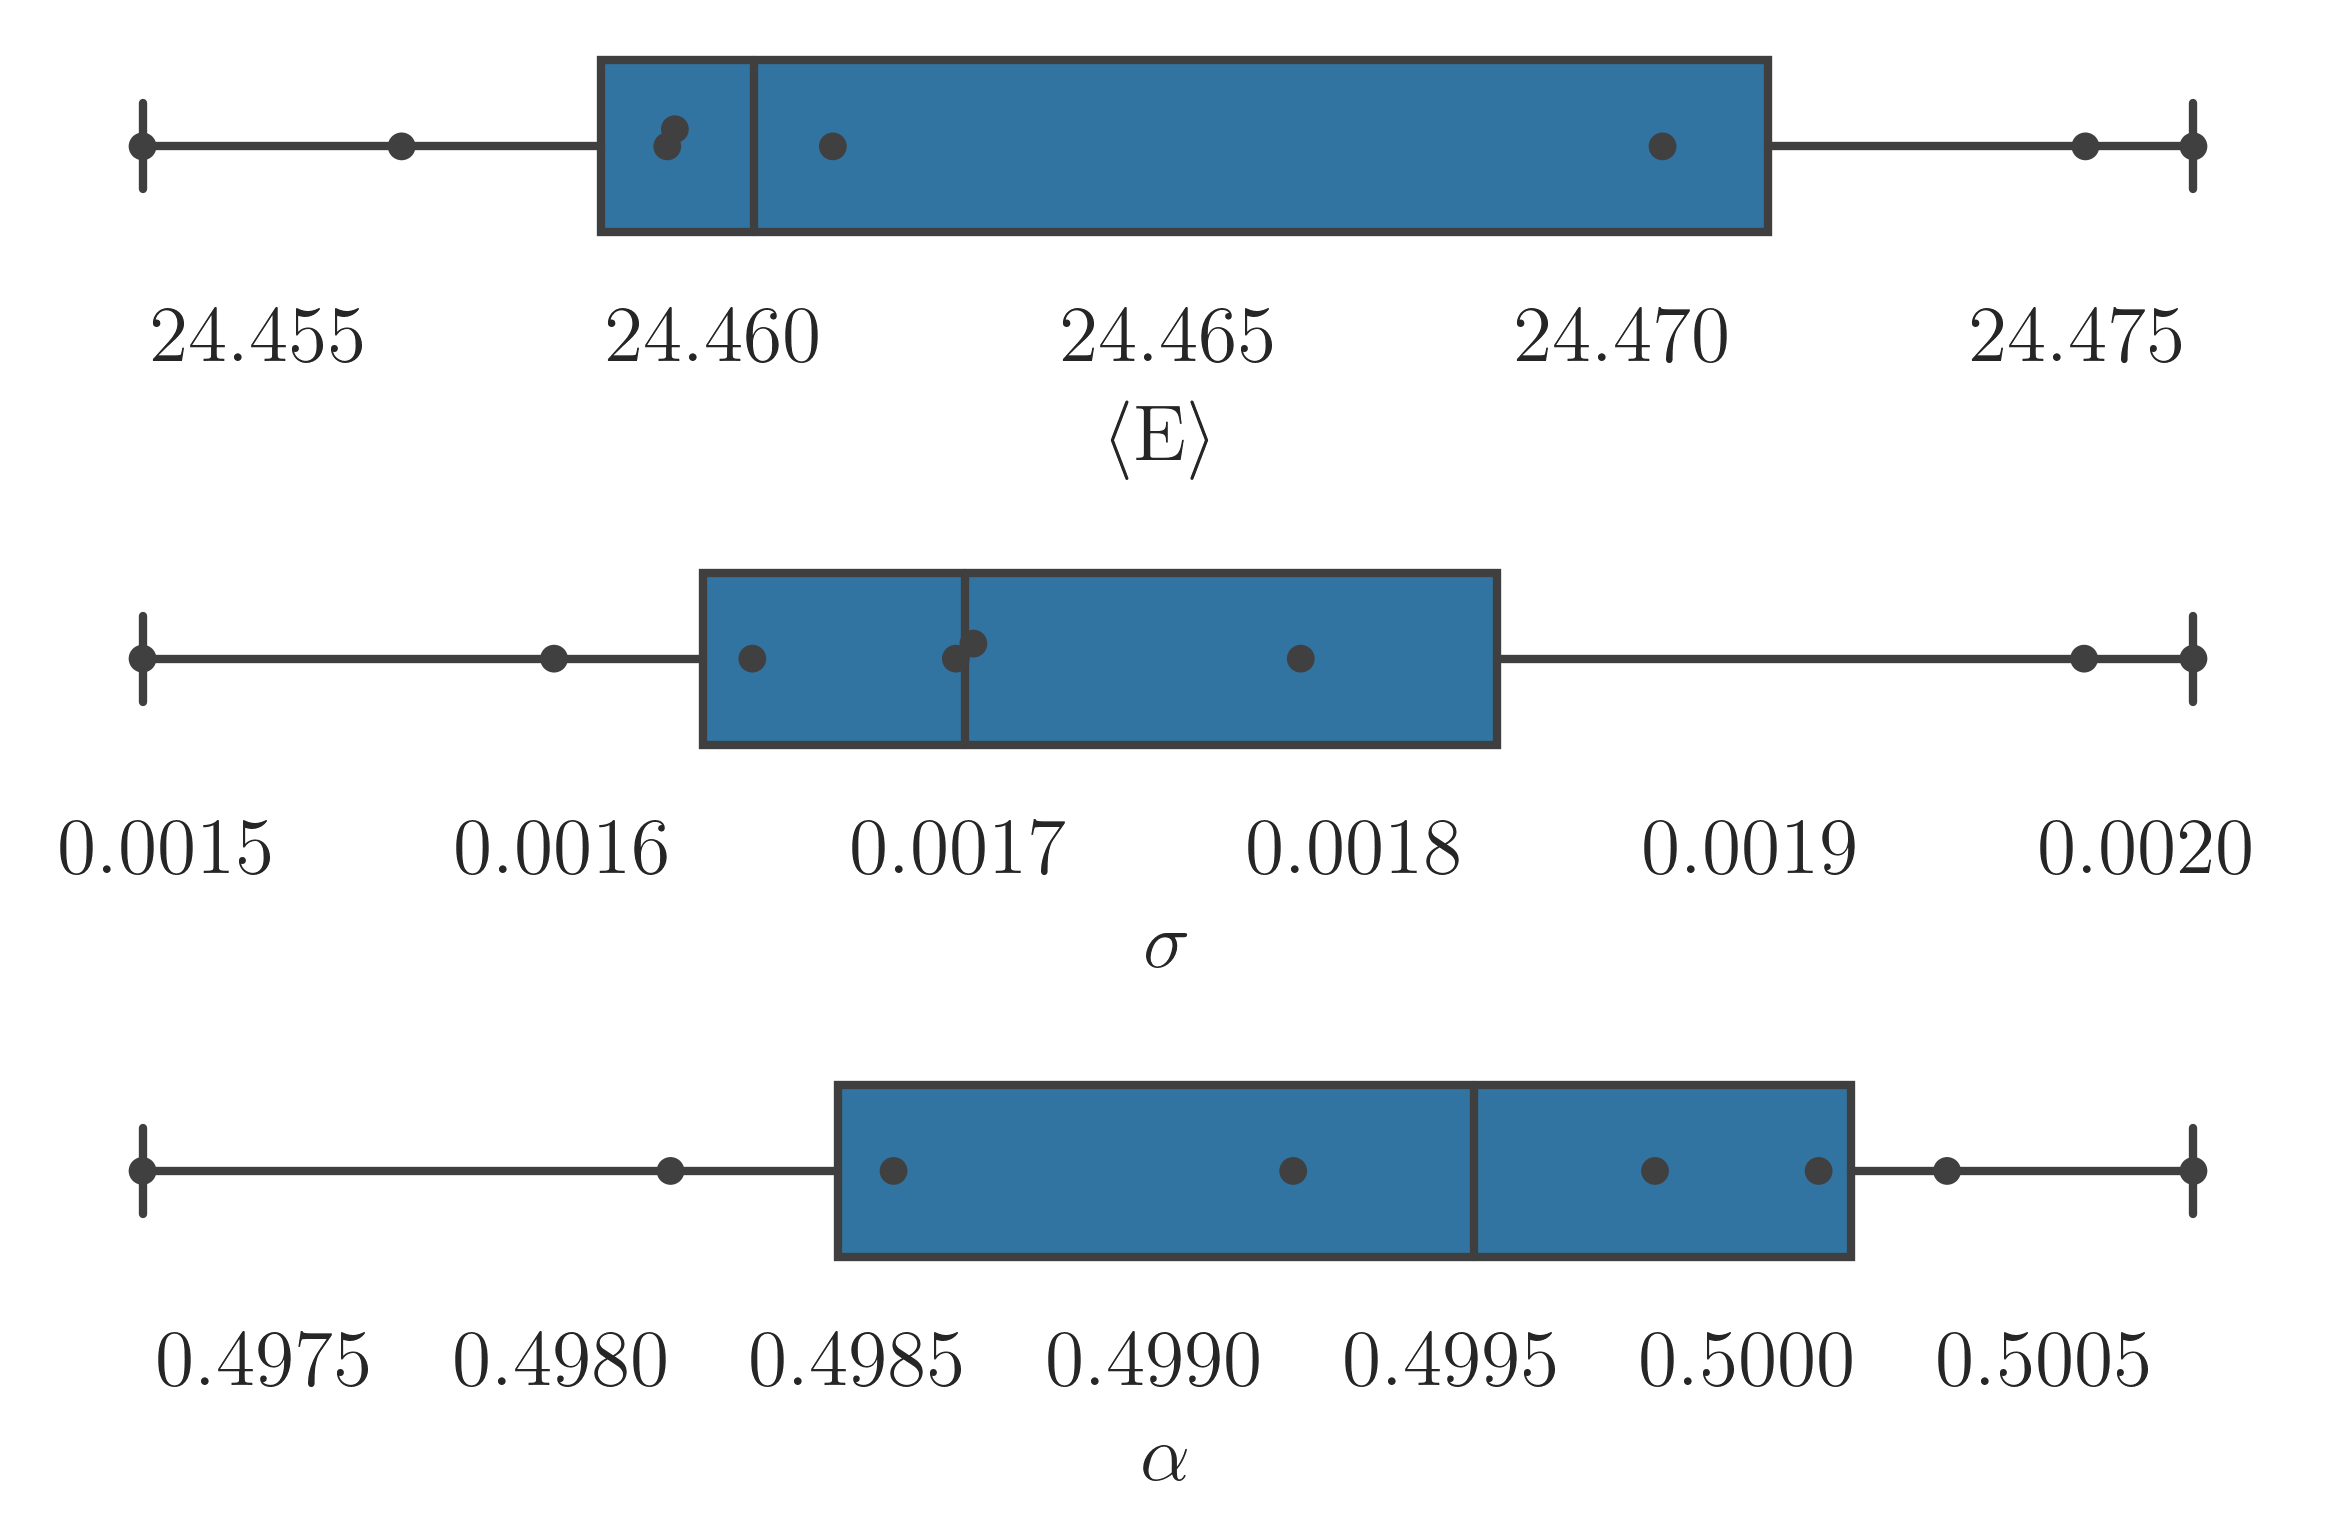

In [113]:
box_plot(results, ["energy", "standard_error", "alpha"], [r'$\langle \mathrm{E}\rangle$', r'$\sigma$', r'$\alpha$'], "bp_E_EHP_N10.pdf")

In [6]:
data_path = "/home/jeb/Documents/FYS4411/FYS4411-Project1/data"
ASHONIB_data = pd.read_csv(data_path + "/grid_search_ashonib_rwm.csv")

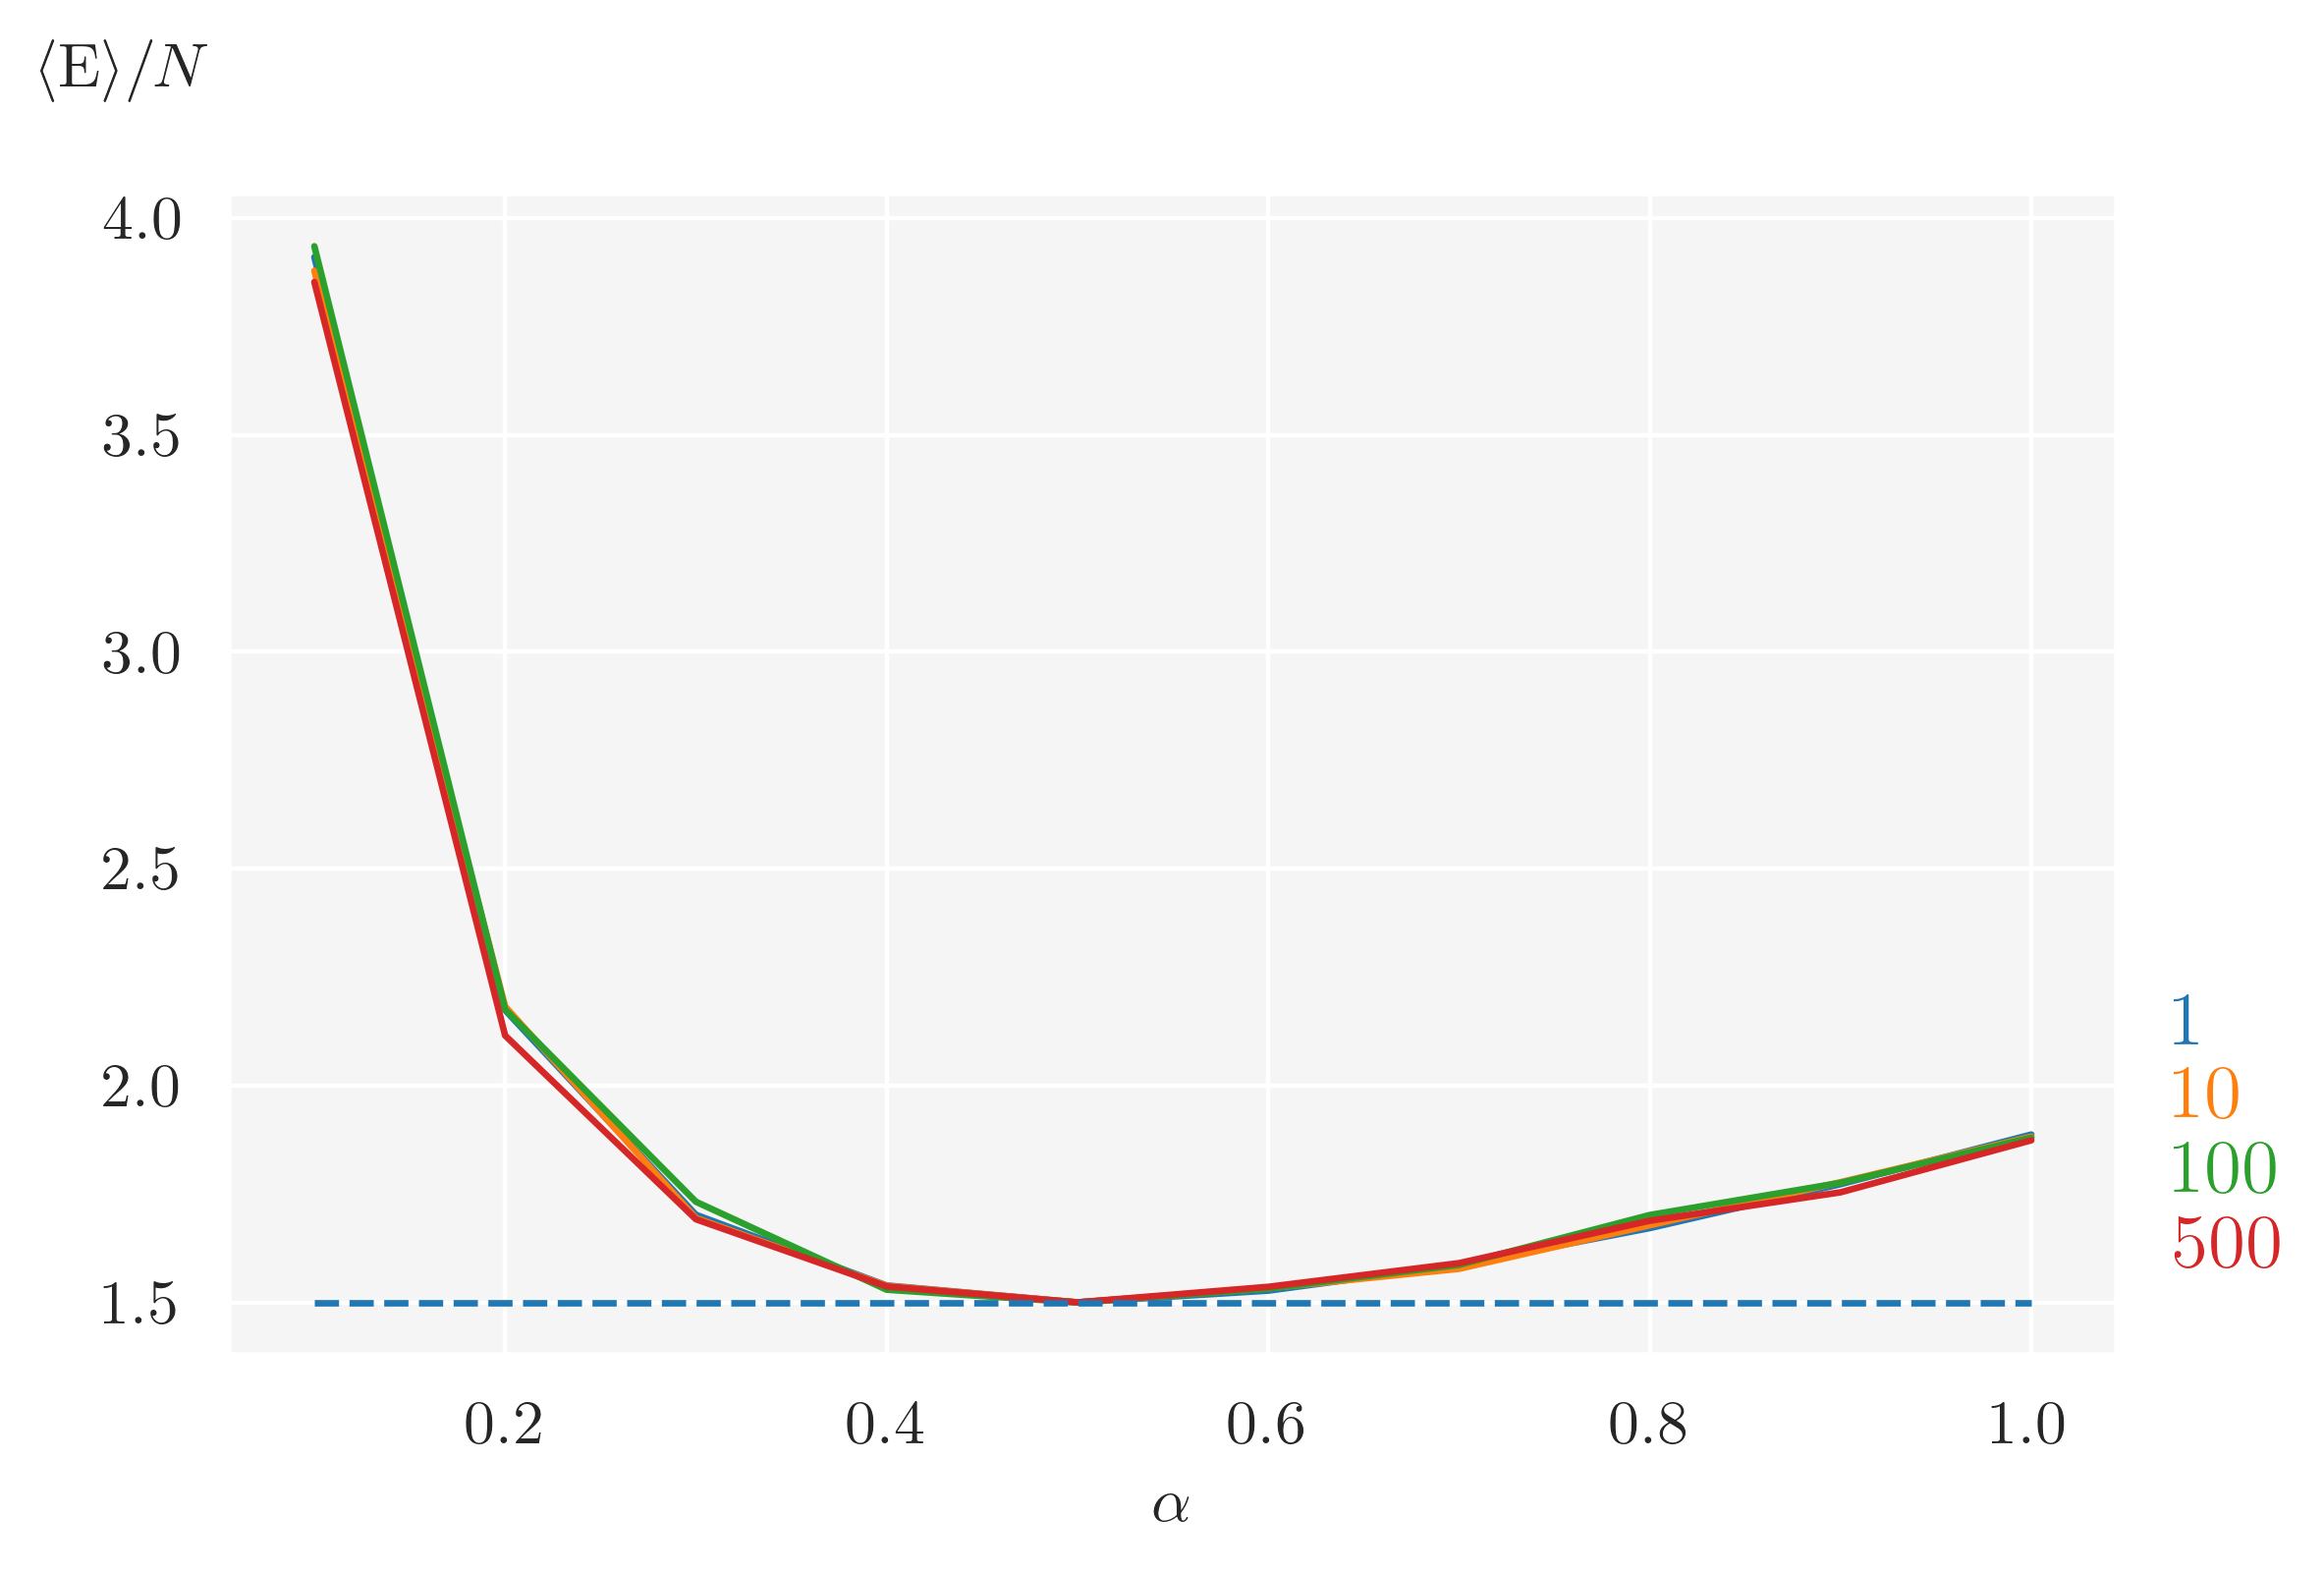

In [24]:
ASHONIB_means = {"N": [], "alpha": [],"energy": [], "error": []}
N_ = [1, 10, 100, 500]
alphas = np.linspace(0.1, 1.0, 10)
for N in N_: 
    for i, alpha in enumerate(alphas): 
        mean_energy = np.mean(ASHONIB_data["scaled_energy"][ASHONIB_data["alpha"]==alpha][ASHONIB_data["nparticles"]==N])
        mean_std = np.mean(ASHONIB_data["scaled_std_error"][ASHONIB_data["alpha"]==alpha][ASHONIB_data["nparticles"]==N])
        ASHONIB_means["N"].append(N)
        ASHONIB_means["alpha"].append(alpha)
        ASHONIB_means["energy"].append(mean_energy)
        ASHONIB_means["error"].append(mean_std)
        
ASHONIB_means = pd.DataFrame(ASHONIB_means)
ASHONIB_N1 = ASHONIB_means[ASHONIB_means["N"]==1]
ASHONIB_N10 = ASHONIB_means[ASHONIB_means["N"]==10]
ASHONIB_N100 = ASHONIB_means[ASHONIB_means["N"]==100]
ASHONIB_N500 = ASHONIB_means[ASHONIB_means["N"]==500]

data_list = [ASHONIB_N1, ASHONIB_N10, ASHONIB_N100, ASHONIB_N500]

line_plot_no_error(data_list, ["alpha", "energy"], ["1", "10", "100", "500"], r'$\alpha$', r'$\langle\mathrm{E}\rangle/N$', "grid_search_RWM_spherical.pdf" )
            

In [9]:
AEHONIB_data = pd.read_csv(data_path +  "/aehonib.csv")
AEHONIB_data

,chain_id,nparticles,dim,scale,eta,alpha,energy,std_error,variance,scaled_energy,scaled_std_error,scaled_variance,accept_rate,nsamples,total_cycles,warmup_cycles,tuning_cycles,optimize_cycles
0,1,10,3,0.194872,0.01,0.500782,24.142412,0.000304,0.000247,2.414241,0.000304,0.000247,0.374454,262144,375144,5000,11000,97000
1,2,10,3,0.194872,0.01,0.502515,24.144200,0.000852,0.002320,2.414420,0.000852,0.002320,0.375935,262144,352144,5000,11000,74000
2,3,10,3,0.194872,0.01,0.500112,24.142164,0.000043,0.000005,2.414216,0.000043,0.000005,0.379044,262144,378144,5000,11000,100000
3,4,10,3,0.194872,0.01,0.504094,24.145205,0.001509,0.006095,2.414521,0.001509,0.006095,0.375149,262144,345144,5000,11000,67000
4,1,10,3,0.194872,0.01,0.500514,24.142174,0.000204,0.000106,2.414217,0.000204,0.000106,0.372971,262144,376144,5000,12000,97000
5,2,10,3,0.235795,0.01,0.499089,24.141999,0.000298,0.000252,2.414200,0.000298,0.000252,0.276077,262144,376144,5000,15000,94000
6,3,10,3,0.194872,0.01,0.498593,24.141752,0.000519,0.000752,2.414175,0.000519,0.000752,0.378403,262144,365144,5000,12000,86000
7,4,10,3,0.194872,0.01,0.499775,24.142089,0.000083,0.000019,2.414209,0.000083,0.000019,0.376503,262144,378144,5000,11000,100000
8,1,10,3,0.214359,0.01,0.502492,24.143293,0.000867,0.002080,2.414329,0.000867,0.002080,0.325092,262144,350144,5000,12000,71000
9,2,10,3,0.214359,0.01,0.501216,24.142864,0.000403,0.000471,2.414286,0.000403,0.000471,0.325298,262144,377144,5000,12000,98000


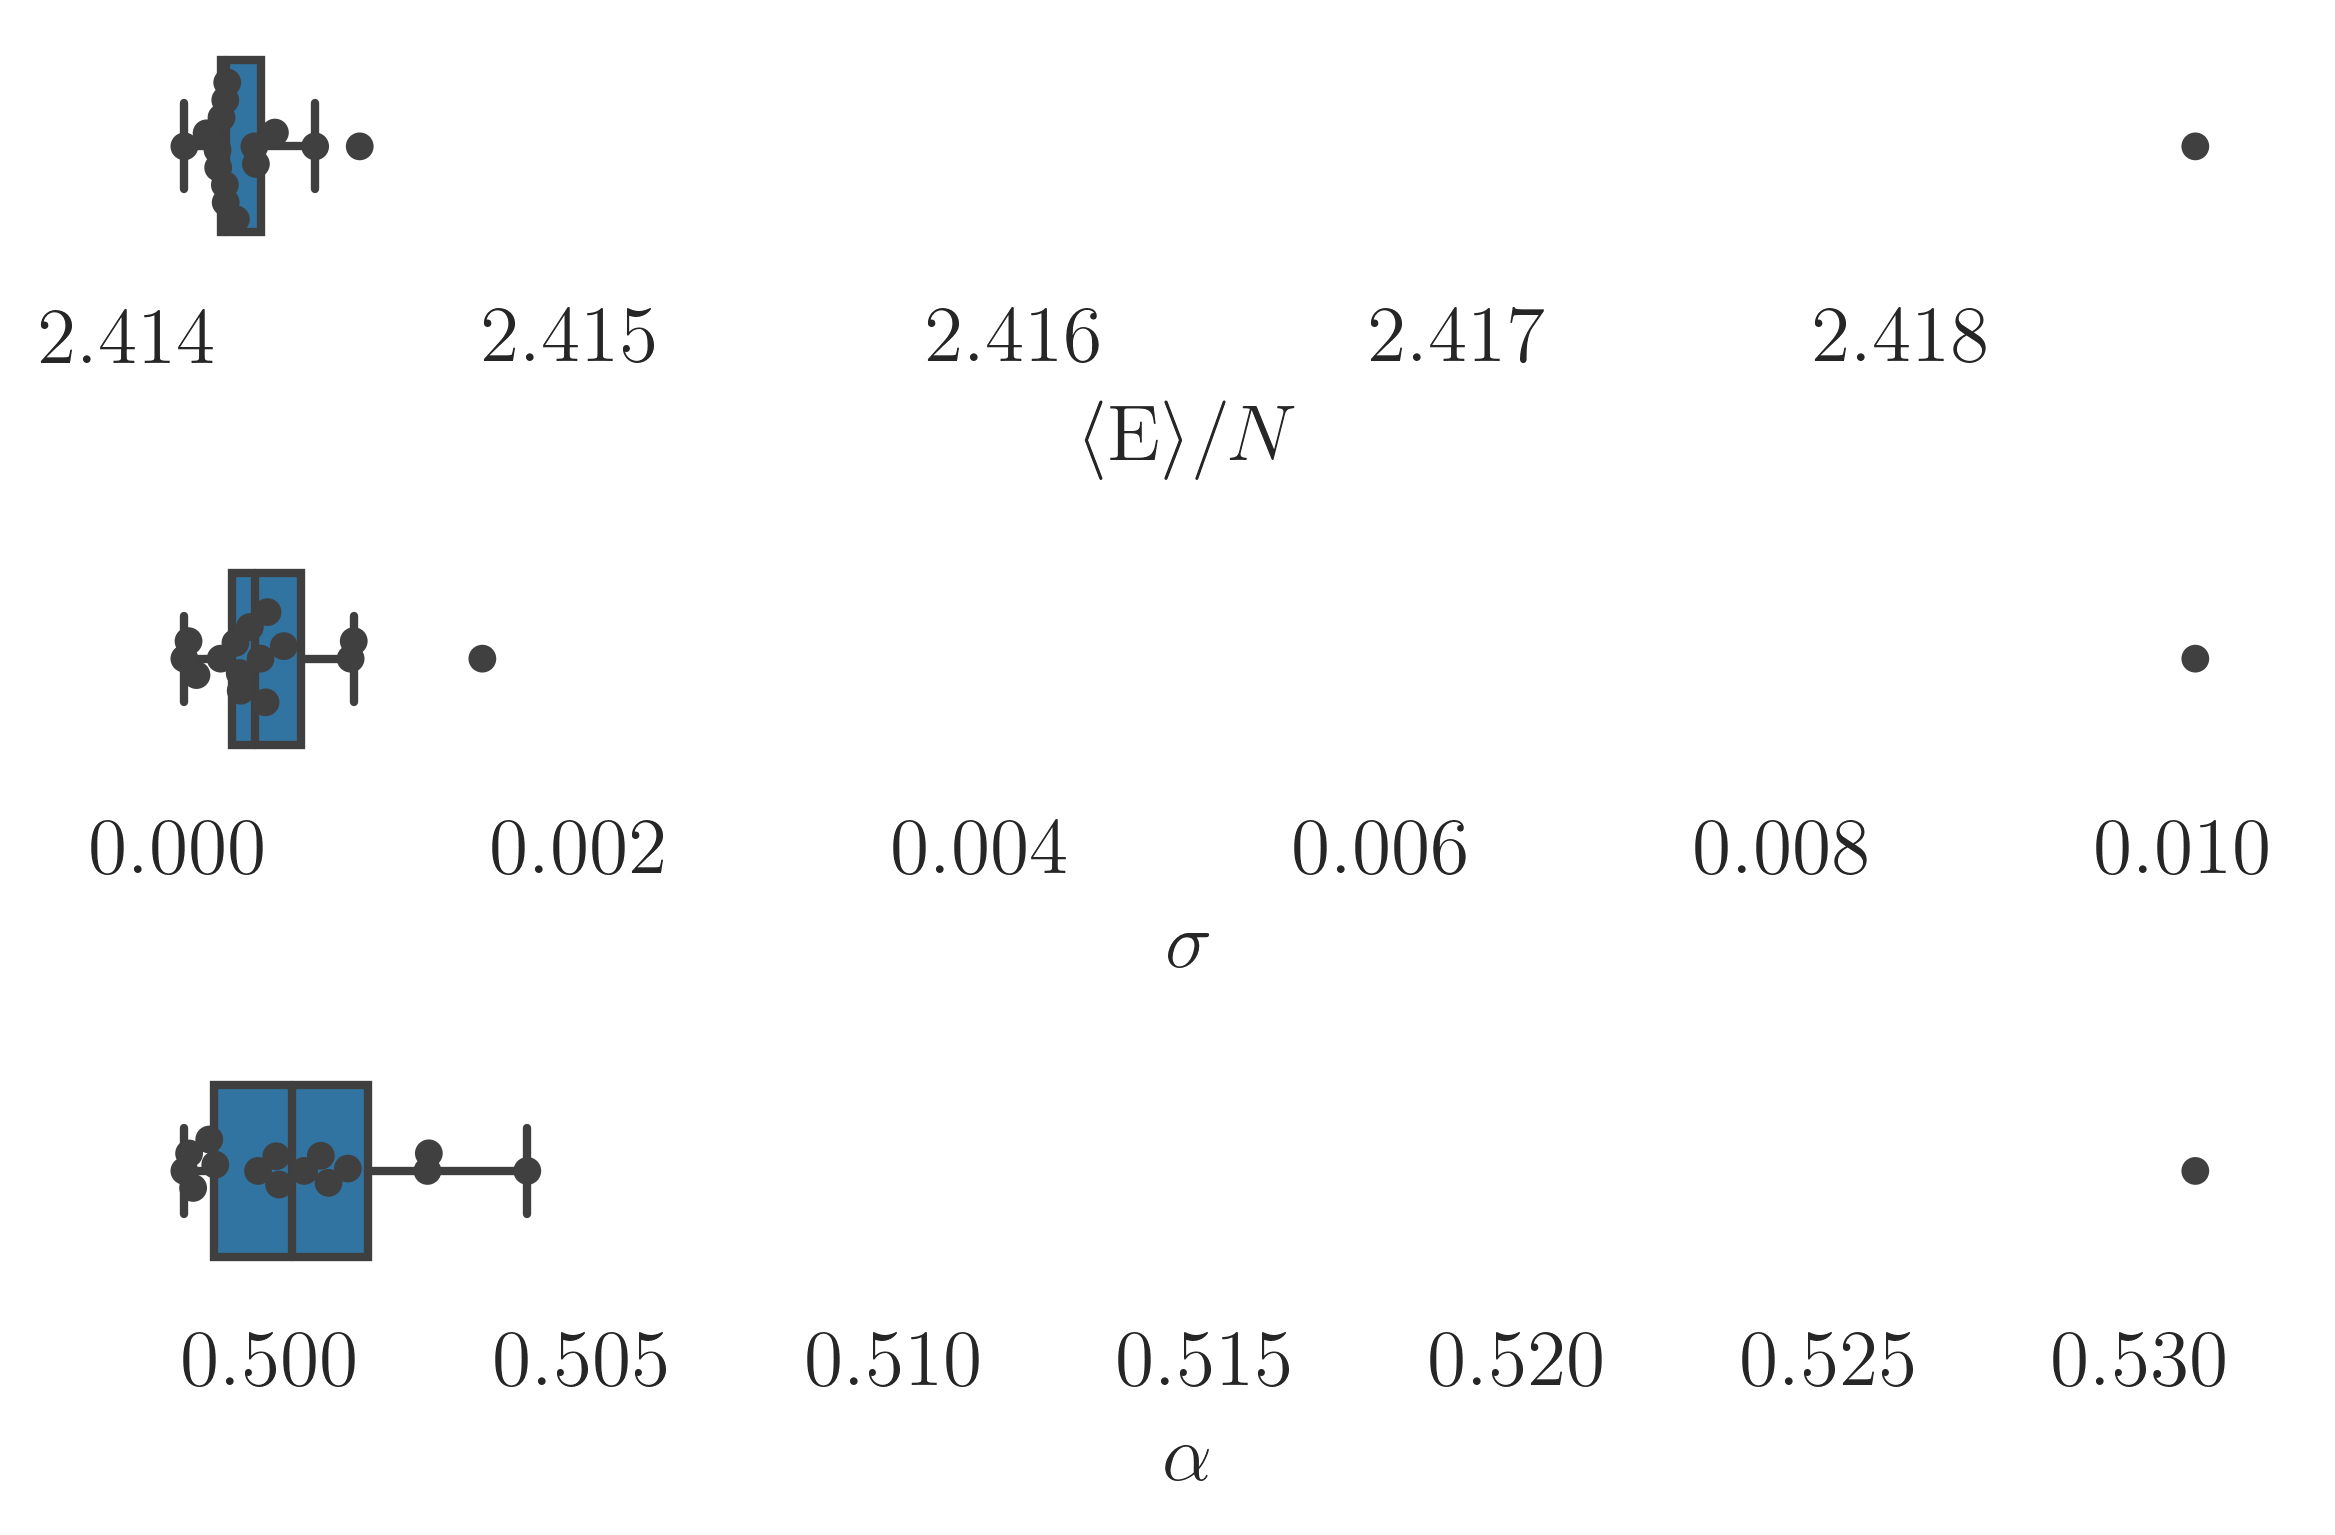

In [27]:


box_plot(AEHONIB_data, ["scaled_energy", "scaled_std_error", "alpha"], [r'$\langle \mathrm{E}\rangle/N$', r'$\sigma$', r'$\alpha$'], "aehonib_opt.pdf")

24.46439019785126


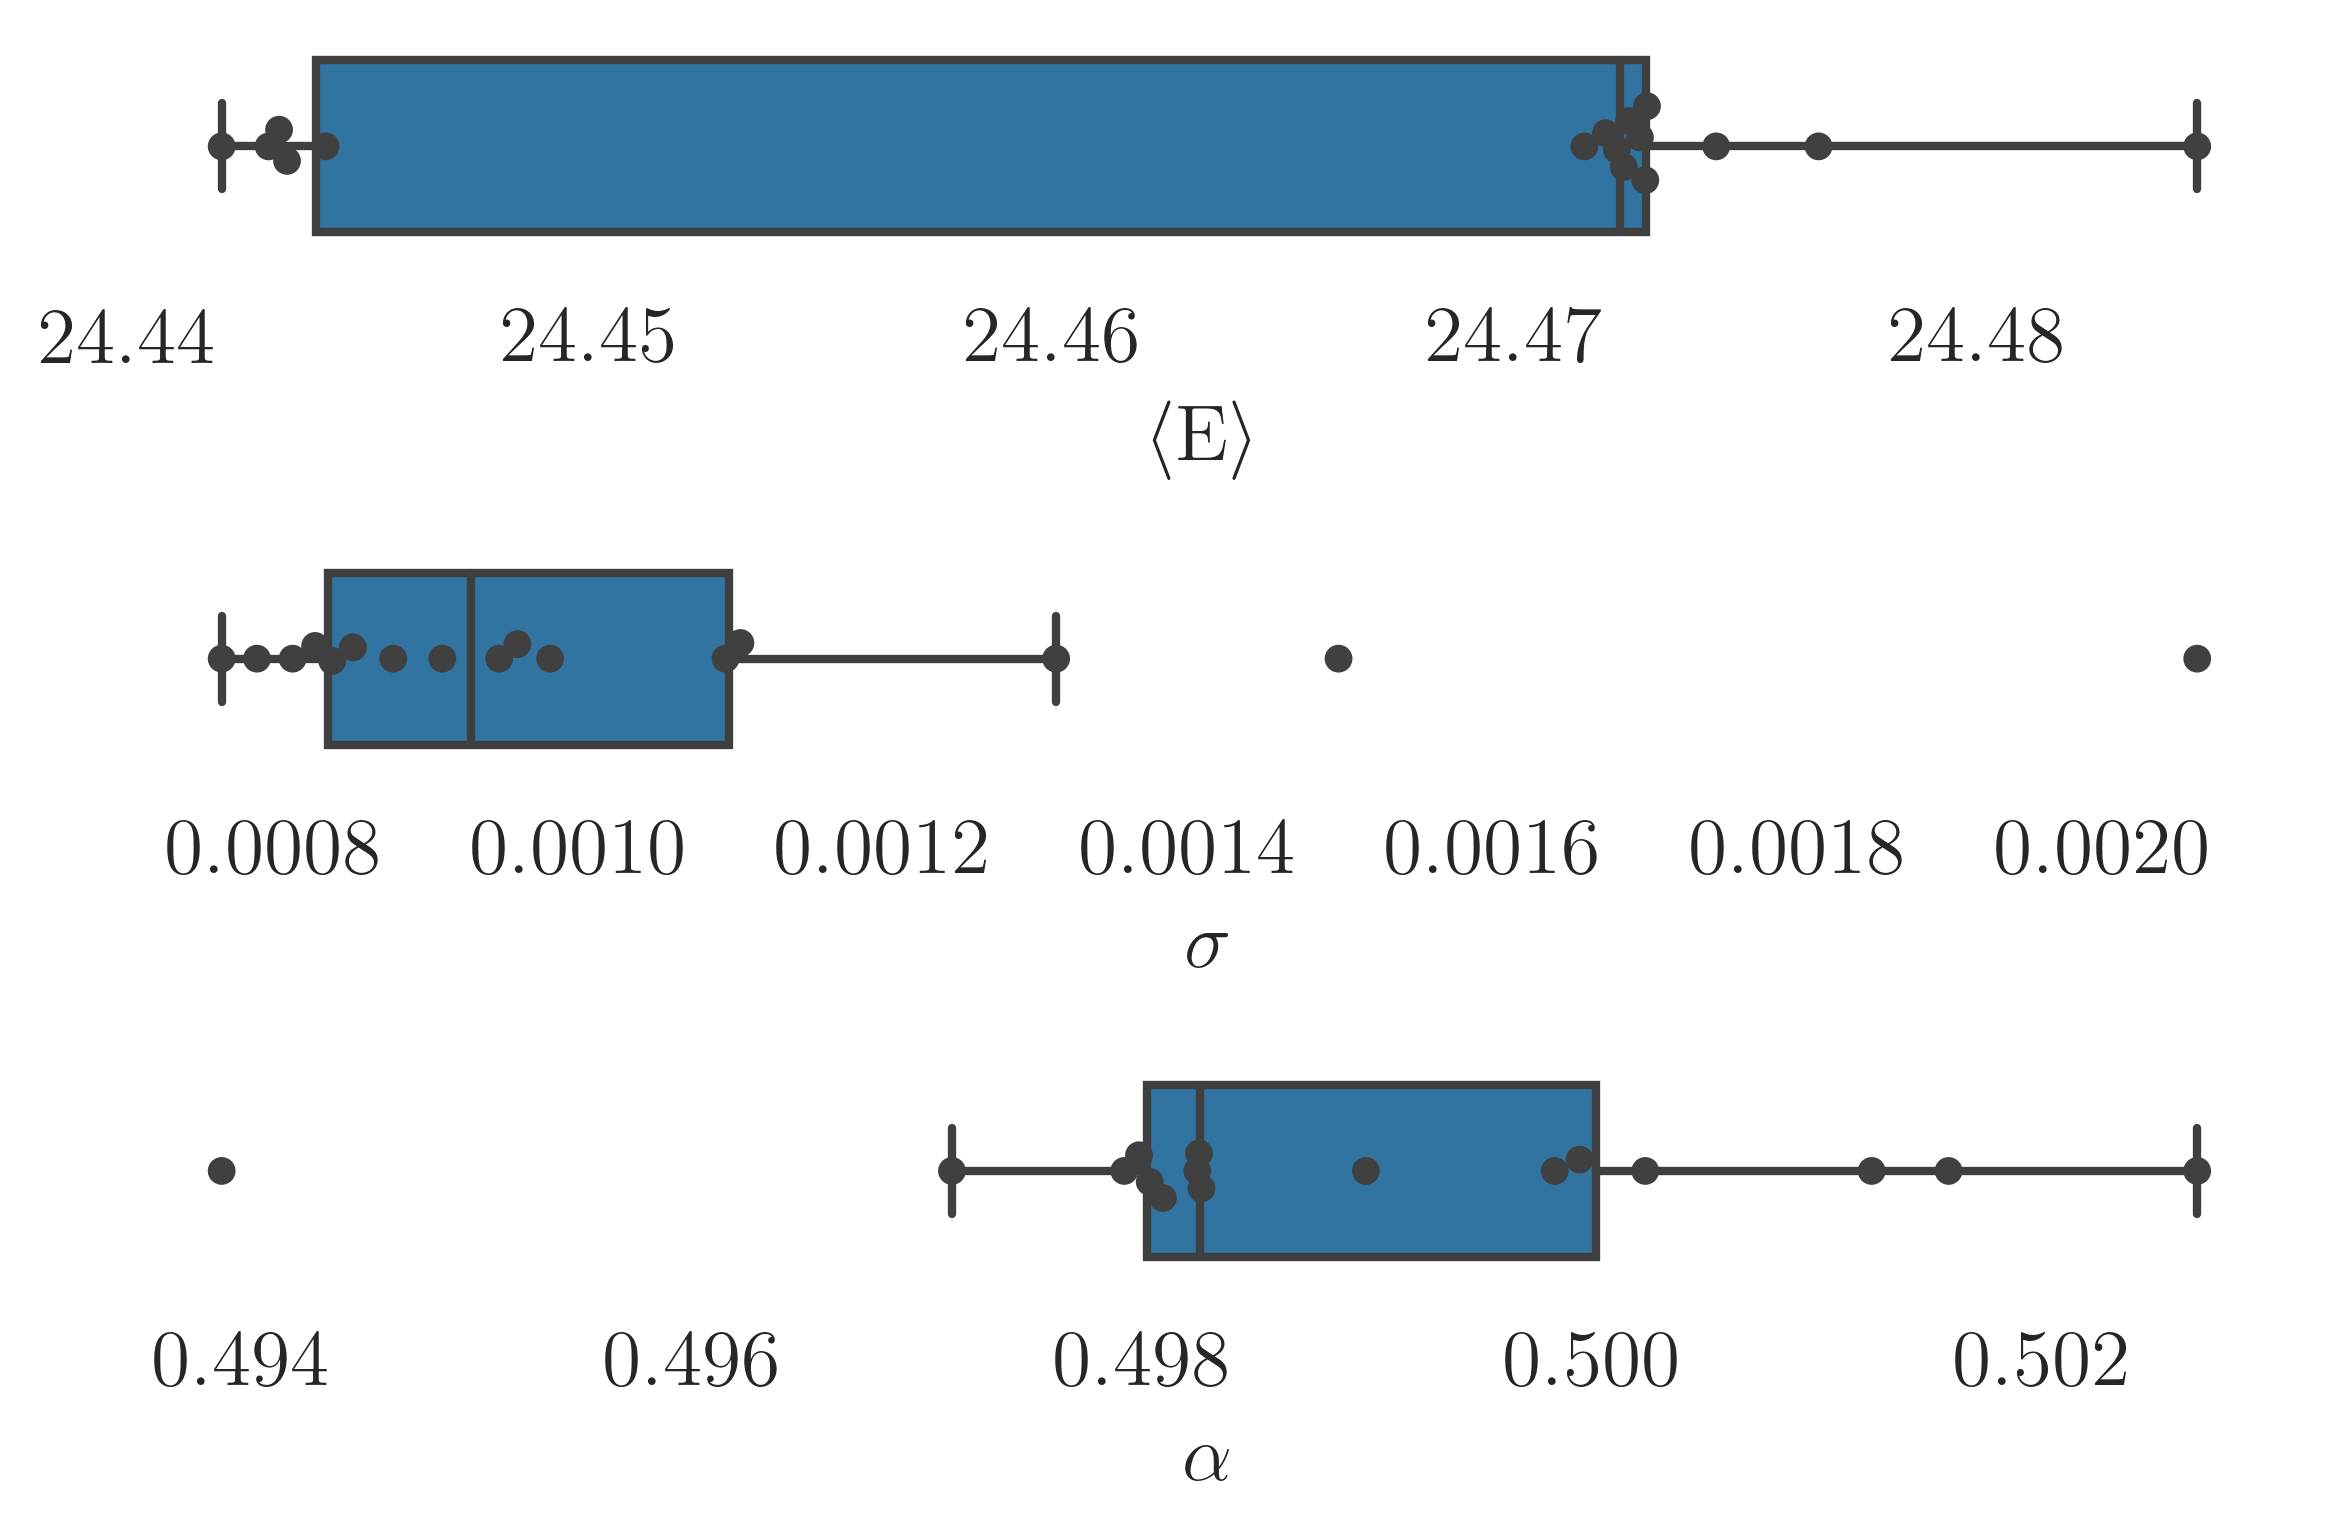

In [30]:
aehoib_data = pd.read_csv(data_path +  "/aehoib.csv")
box_plot(aehoib_data, 
         ["energy", "std_error","alpha"],
         [r'$\langle \mathrm{E}\rangle$', r'$\sigma$', r'$\alpha$'], 
         "aehoib_bp.pdf",
        )
mean_energy = np.mean(aehoib_data["energy"])
print(mean_energy)